# An Expenonetially Weighted Covariance Matrix in R

Exponential weighting schemes can help navigate the trade-off between responsiveness and stability of the inherently noisy estimates we make from market data. 

We previously saw examples of calculating the exponentially weighted moving average of a vector, and estimating the correlation between SPY and TLT using an exponential weighting scheme [[link](https://robotwealth.com/using-exponentially-weighted-moving-averages-to-navigate-trade-offs-in-systematic-trading/)]. 

In this article, we'll implement an exponentially weighted covariance matrix for a portfolio of assets.

## Why care about covariance in trading?

Covariance describes the extent of co-movement between two assets. 

From pair-wise covariances between assets in a portfolio, we can get the variance of the portfolio quite easily - it's just the weighted sum of the covariances, given by $w^T \Sigma w$ where $w$ is a vector representing the weights of each asset in the portfolio and $\Sigma$ is the covariance matrix. (Getting portfolio variance from the *correlation* matrix is a slightly more difficult computation).

And we can use the variance of the portfolio as a measure of risk. 

So you see how a good forecast of covariance can be of benefit in portfolio construction. 

I would like to use *historical* covariance as my forecast of *future* covariance. So firstly, let's see if that stacks up. We'll pull some data from Yahoo Finance into an R session and look at the relationship between past and future pair-wise covariances for a 3-asset ETF portfolio (SPY, TLT, GLD). We'll start by estimating covariance over an equally weighted fixed window length (that is, no exponential weighting).

The functions being sourced in the code block below get data from Yahoo Finance and come from [here](https://robotwealth.com/yahoo-prices-r-easy/).

In [2]:
library(tidyverse)
library(roll)

# Set chart options
options(repr.plot.width = 14, repr.plot.height=7, warn=-1)
theme_set(theme_bw())
theme_update(text = element_text(size = 20))

# functions for getting prices from Yahoo Finance
source("../data_tools/yahoo_prices.R")

In [3]:
# get data
tickers <- c("TLT", "SPY", "GLD")
prices <- yahoo_prices(
    tickers,
    from_date = "2004-11-18",
    to_date = "2023-11-06"
  ) %>% 
  arrange(Date, Ticker)
 
head(prices)

,Date,Ticker,Open,High,Low,Close,Adj.Close,Volume
,<date>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
1,2004-11-17,SPY,118.37,119.14,118.07,118.58,82.37284,54494000
2,2004-11-17,TLT,87.89,88.76,87.89,88.70,48.90133,1249400
3,2004-11-18,GLD,44.43,44.49,44.07,44.38,44.38000,5992000
4,2004-11-18,SPY,118.53,118.80,118.23,118.74,82.48396,31854300
5,2004-11-18,TLT,88.55,89.06,88.41,88.97,49.05021,891500
6,2004-11-19,GLD,44.49,44.92,44.47,44.78,44.78000,11655300


In [4]:
# create log returns 
returns <- prices %>%
  group_by(Ticker) %>%
  arrange(Date) %>%
  mutate(
    log_return = log(Adj.Close/dplyr::lag(Adj.Close)),
    fwd_log_return = dplyr::lead(log_return)
  )

# covariance lookback period
wdw <- 90  

# calculate rolling pairwise covariances over period as a long dataframe
rolling_cov <- returns %>%
  na.omit() %>%
  full_join(returns, by = "Date") %>%
  ungroup() %>% 
  # drop diagonal 
  dplyr::filter(Ticker.x != Ticker.y) %>% 
  # get all combinations (Tickers) and remove duplicate combos (eg SPY-TLT, TLT-SPY)
  mutate(Tickers = ifelse(Ticker.x < Ticker.y, glue("{Ticker.x}, {Ticker.y}"), glue("{Ticker.y}, {Ticker.x}"))) %>%
  distinct(Date, Tickers, .keep_all = TRUE) %>%
  # calculate rolling pairwise covariances
  group_by(Tickers) %>%
  arrange(Date, .by_group = TRUE) %>%
  mutate(rolling_cov = roll::roll_cov(
    x = log_return.x, 
    y = log_return.y, 
    width = wdw
  )) %>% 
  select(Date, Tickers, rolling_cov)

tail(rolling_cov)

Date,Tickers,rolling_cov
<date>,<chr>,<dbl>
2023-10-26,"SPY, TLT",2.455208e-05
2023-10-27,"SPY, TLT",2.487787e-05
2023-10-30,"SPY, TLT",2.501001e-05
2023-10-31,"SPY, TLT",2.577403e-05
2023-11-01,"SPY, TLT",2.879114e-05
2023-11-02,"SPY, TLT",3.412896e-05


Here's a plot of rolling pairwise covariances:

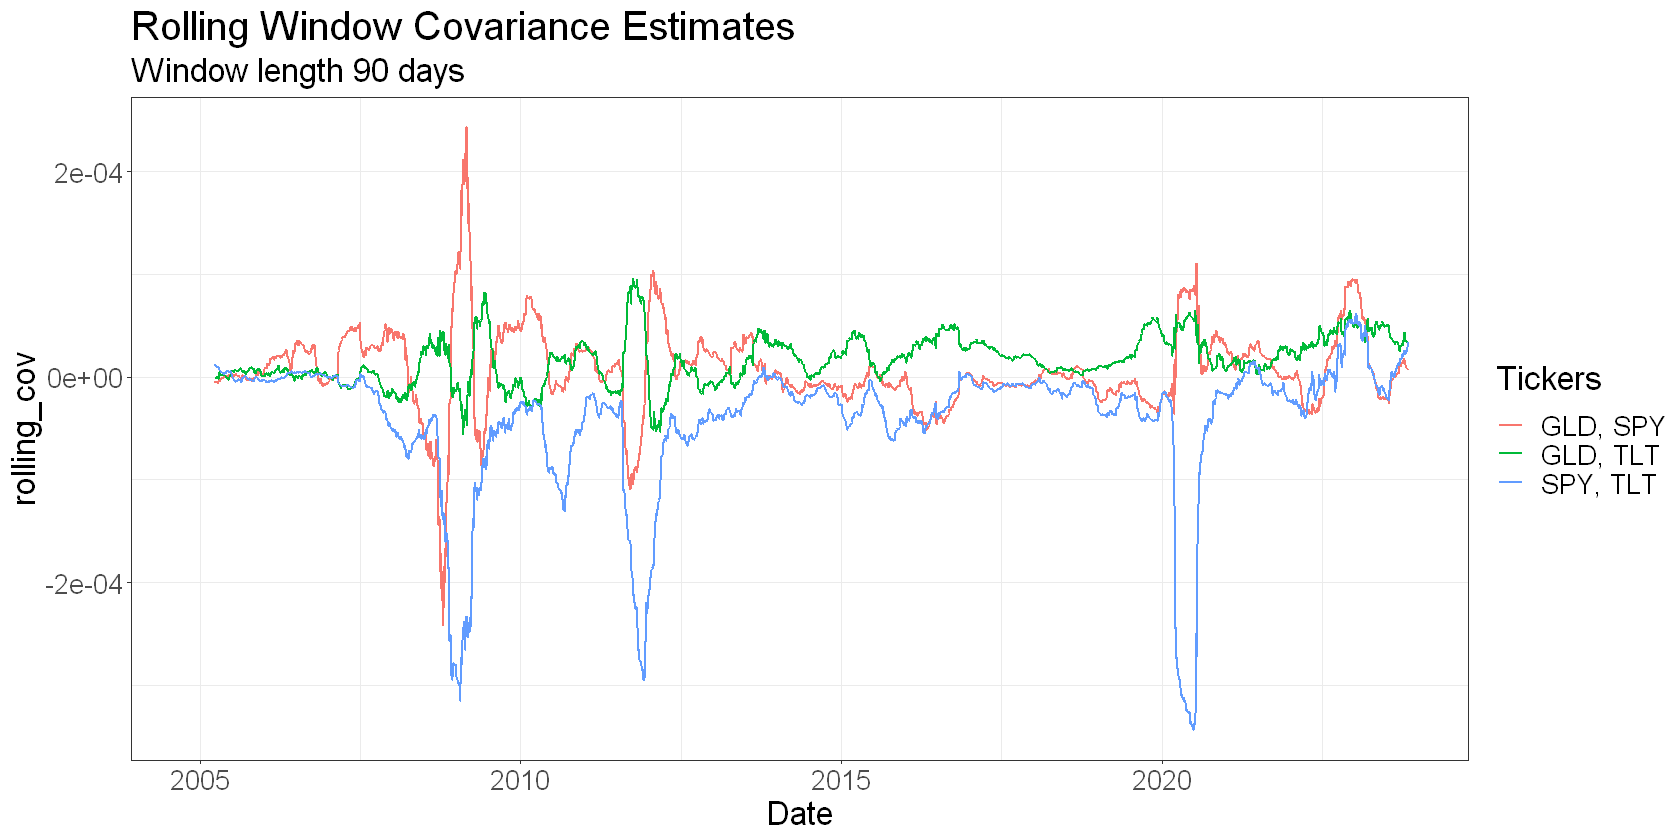

In [5]:
# plot pairwise rolling covariances
rolling_cov %>%
  ggplot(aes(x = Date, y = rolling_cov, colour = Tickers)) +
    geom_line(size=0.8) +
    # facet_wrap(~Tickers, ncol = 1) +
    labs(
      title = "Rolling Window Covariance Estimates",
      subtitle = glue("Window length {wdw} days"),
      colour = "Tickers"
    )

Next we look at whether past covariance is predictive of future covariance. We take non-overlapping periods and compare the covariance in one period to the covariance in the next. 

`geom_smooth()` using formula = 'y ~ x'


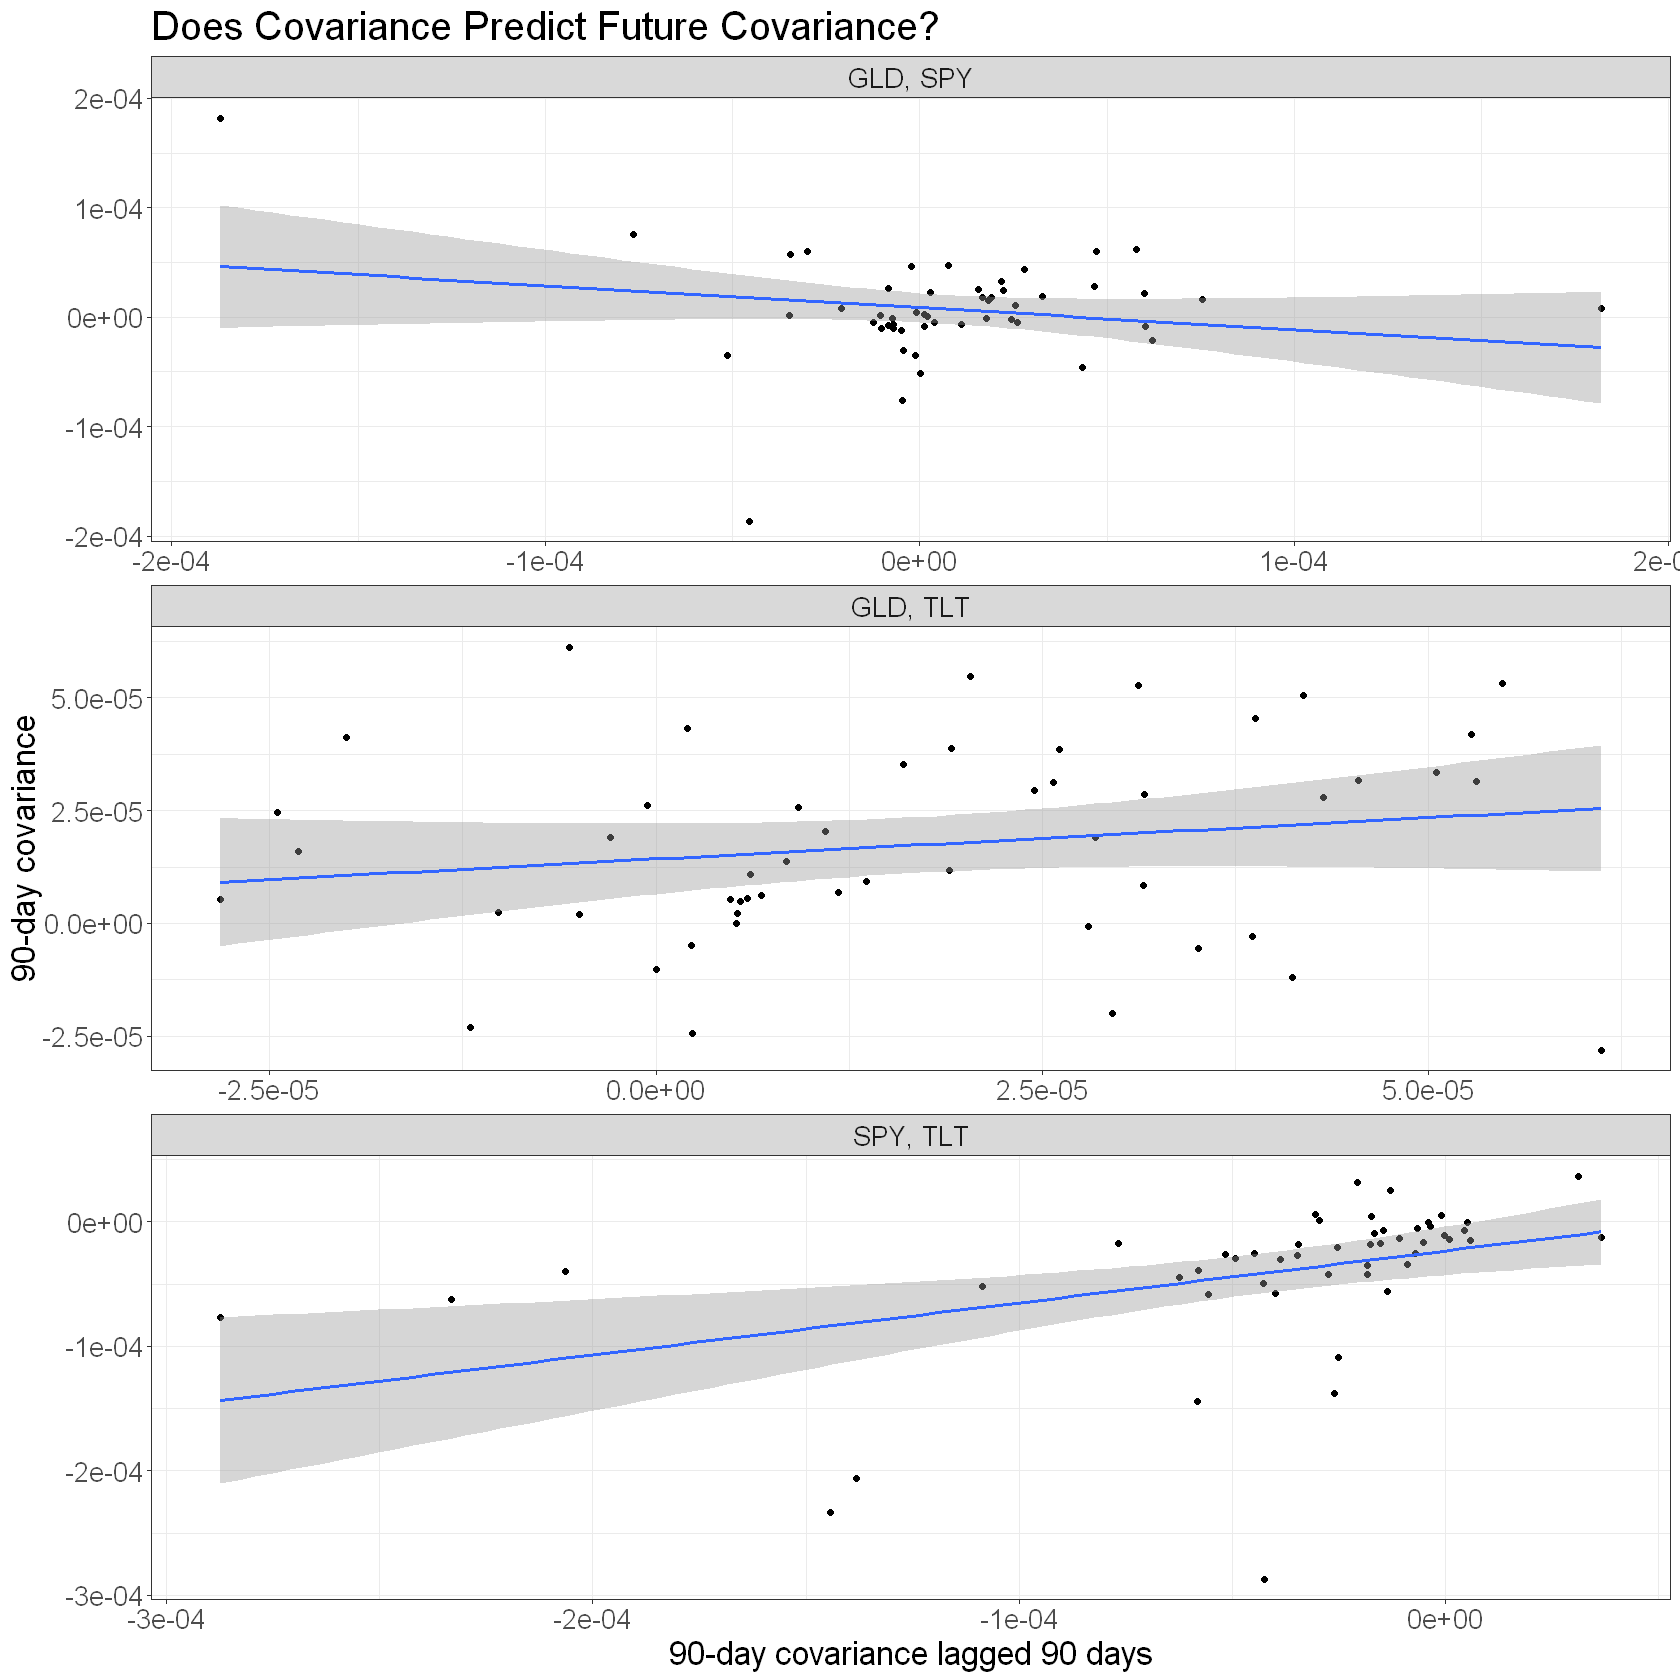

In [6]:
options(repr.plot.width = 14, repr.plot.height=14)
rolling_cov %>% 
  group_by(Tickers) %>%
  mutate(cov_lag = dplyr::lag(rolling_cov, wdw)) %>%
  na.omit() %>%
  # remove overlapping data
  dplyr::filter(row_number() %% wdw == 0) %>%
  ggplot(aes(x = cov_lag, y = rolling_cov)) +
    geom_point() +
    geom_smooth(method = lm) +
    facet_wrap(~Tickers, ncol=1, scales = 'free') +
    labs(
      x = glue::glue("{wdw}-day covariance lagged {wdw} days"),
      y = glue::glue("{wdw}-day covariance"),
      title = "Does Covariance Predict Future Covariance?"
    )

The first thing that stands out is that any relationship between past and future covariance is extremely noisy at best. 

The covariances of SPY-TLT and GLD-TLT are noisily "sticky" on average. If their covariance was high recently, then it's slightly more likely to be high in the next period. 

The GLD-SPY covariance showed the opposite relationship on average. If their covariance was high recently, then it's slightly more likely to be low in the next period. 

But that relationship seems to be driven by the large outlier in the top left of the chart above. Take that data point out, and the relationship looks a lot more like SPY-TLT and GLD-TLT. (For what it's worth, that data point occurred in February 2009 - certainly an unusual time).

So based on the data above, let's say that covariance is *weakly and noisily* predictive of future covariance. 

In addition, the previous time series plot of rolling covariance shows that our covariance estimate wiggles around all over the place. 

You can imagine that if my covariance forecast is unstable, that I'd be hyperactively changing my portfolio weights in response to this perceived change in risk. But those short-term fluctuations are mostly just noise, so maybe I can smooth out my estimate of historical covariance without losing a great deal of information. 

So we'll implement an exponentially weighted covariance matrix to try to smooth things out a bit. 

## An exponentially weighted covariance

This approach to implemetning an exponentially weighted covariance is based on equations 5.6 and 5.7 in [Risk Metrics](https://www.msci.com/documents/10199/5915b101-4206-4ba0-aee2-3449d5c7e95a) (page 83):

$$\Sigma_{1,2,t} = λ(\Sigma_{1,2,t-1}) + (1 - \lambda)*(r_{1,t-1}*r_{2,t-1})$$

where $\Sigma_{1,2,t}$ is the covariance between assets $1$ and $2$ at time $t$, $r_{1,t}$ and $r_{2,t}$ are the returns of assets $1$ and $2$ at time $t$, and $\lambda$ is the exponential decay factor. 

At the start of the calculation, I initialise $\Sigma$ to the covariance over some initial window, and $r_1$ and $r_2$ to the mean returns of the two assets over that same initial window.

In [7]:
# EWMA covariance estimate
# note definition of lambda in line with Risk Metrics
# ie higher values of lambda put less weight on the most recent returns and more weight on historical returns.
ewma_cov <- function(x, y, lambda, initialisation_wdw = 100) {
  # TODO: 
    # check that x and y are the same length and greater than initialisation_wdw
    # check NA removed
  
  # create initialisation window and estimation window
  init_x = x[1:initialisation_wdw]
  init_y = y[1:initialisation_wdw]

  num_obs <- length(x)
  
  # initial covariance and mean return estimates
  old_cov <- cov(init_x, init_y)
  old_x <- mean(init_x)
  old_y <- mean(init_y)
  
  # preallocate output vector
  ewma_cov <- vector(mode = "numeric", length = num_obs)

  # pad with NA for initialisation window
  ewma_cov[1:initialisation_wdw] <- NA
  
  # covariance estimate
  for(i in c((initialisation_wdw+1):num_obs)) { 
    ewma_cov[i] <- lambda*old_cov + (1 - lambda)*(old_x * old_y)
    old_cov <- ewma_cov[i]
    old_x <- x[i]
    old_y <- y[i]
  }
  ewma_cov
}

Here's how we can get a long dataframe of EW covariances using this function:

In [8]:
lambda <- 0.98
wdw <- 90

ewma_covs <- returns %>%
  full_join(returns, by = "Date") %>%
  na.omit() %>%
  ungroup() %>% 
  # drop diagonal 
  dplyr::filter(Ticker.x != Ticker.y) %>% 
  # get all combinations (Tickers) and remove duplicate combos (eg SPY-TLT, TLT-SPY)
  mutate(Tickers = ifelse(Ticker.x < Ticker.y, glue("{Ticker.x}, {Ticker.y}"), glue("{Ticker.y}, {Ticker.x}"))) %>%
  distinct(Date, Tickers, .keep_all = TRUE) %>%
  # calculate rolling pairwise ewma correlations
  group_by(Tickers) %>%
  arrange(Date, .by_group = TRUE) %>%
  mutate(ewma_cov = ewma_cov(log_return.x, log_return.y, lambda = lambda, initialisation_wdw = wdw)) %>%
  select(Date, Tickers, ewma_cov) %>%
  na.omit()

tail(ewma_covs)

Date,Tickers,ewma_cov
<date>,<chr>,<dbl>
2023-10-26,"SPY, TLT",2.871603e-05
2023-10-27,"SPY, TLT",2.447412e-05
2023-10-30,"SPY, TLT",2.437151e-05
2023-10-31,"SPY, TLT",2.281108e-05
2023-11-01,"SPY, TLT",2.174214e-05
2023-11-02,"SPY, TLT",2.585833e-05


And here's a plot of the EW covariance and the rolling window version:

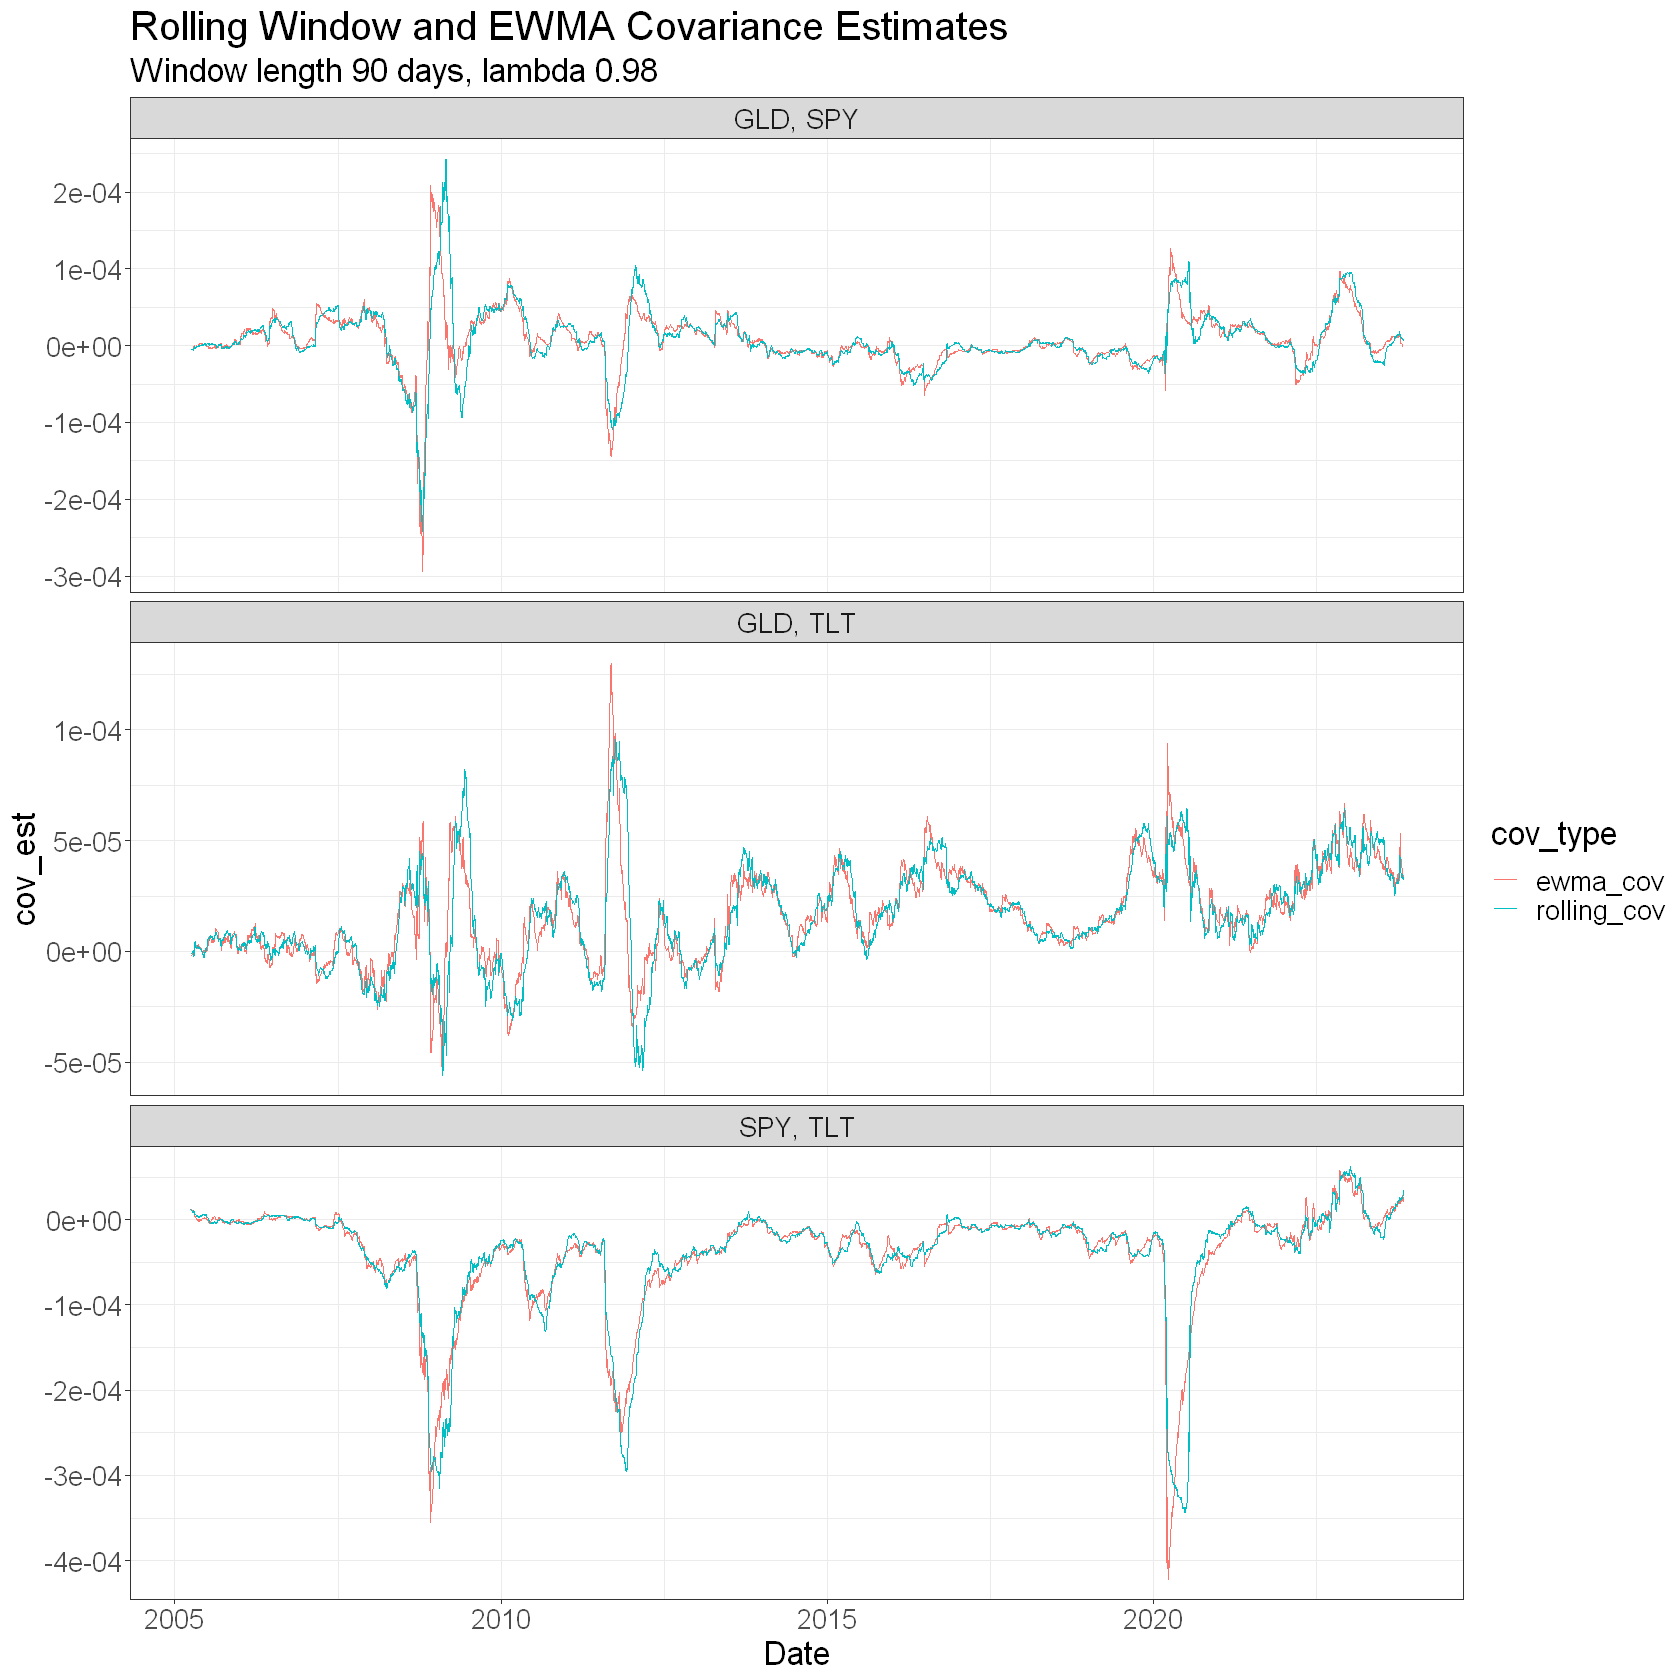

In [9]:
options(repr.plot.width = 14, repr.plot.height=14)
ewma_covs %>%
  left_join(rolling_cov, by = c("Date", "Tickers")) %>%
  pivot_longer(c(-Date, -Tickers), names_to = "cov_type", values_to = "cov_est") %>%
  ggplot(aes(x = Date, y = cov_est, colour = cov_type)) +
    geom_line() +
    facet_wrap(~Tickers, scales = "free_y", ncol = 1) +
    labs(
      title = "Rolling Window and EWMA Covariance Estimates",
      subtitle = glue("Window length {wdw} days, lambda {lambda}")
    )

The EW covariance looks a little more responsive and possibly more stable - although it does wiggle around quite a lot. 

Let's play with the value of lambda to see how the covariance estimate behaves. 

We'll focus on 2020 so that you can see how different values of lambda make the estimate more or less responsive to a significant market event. 

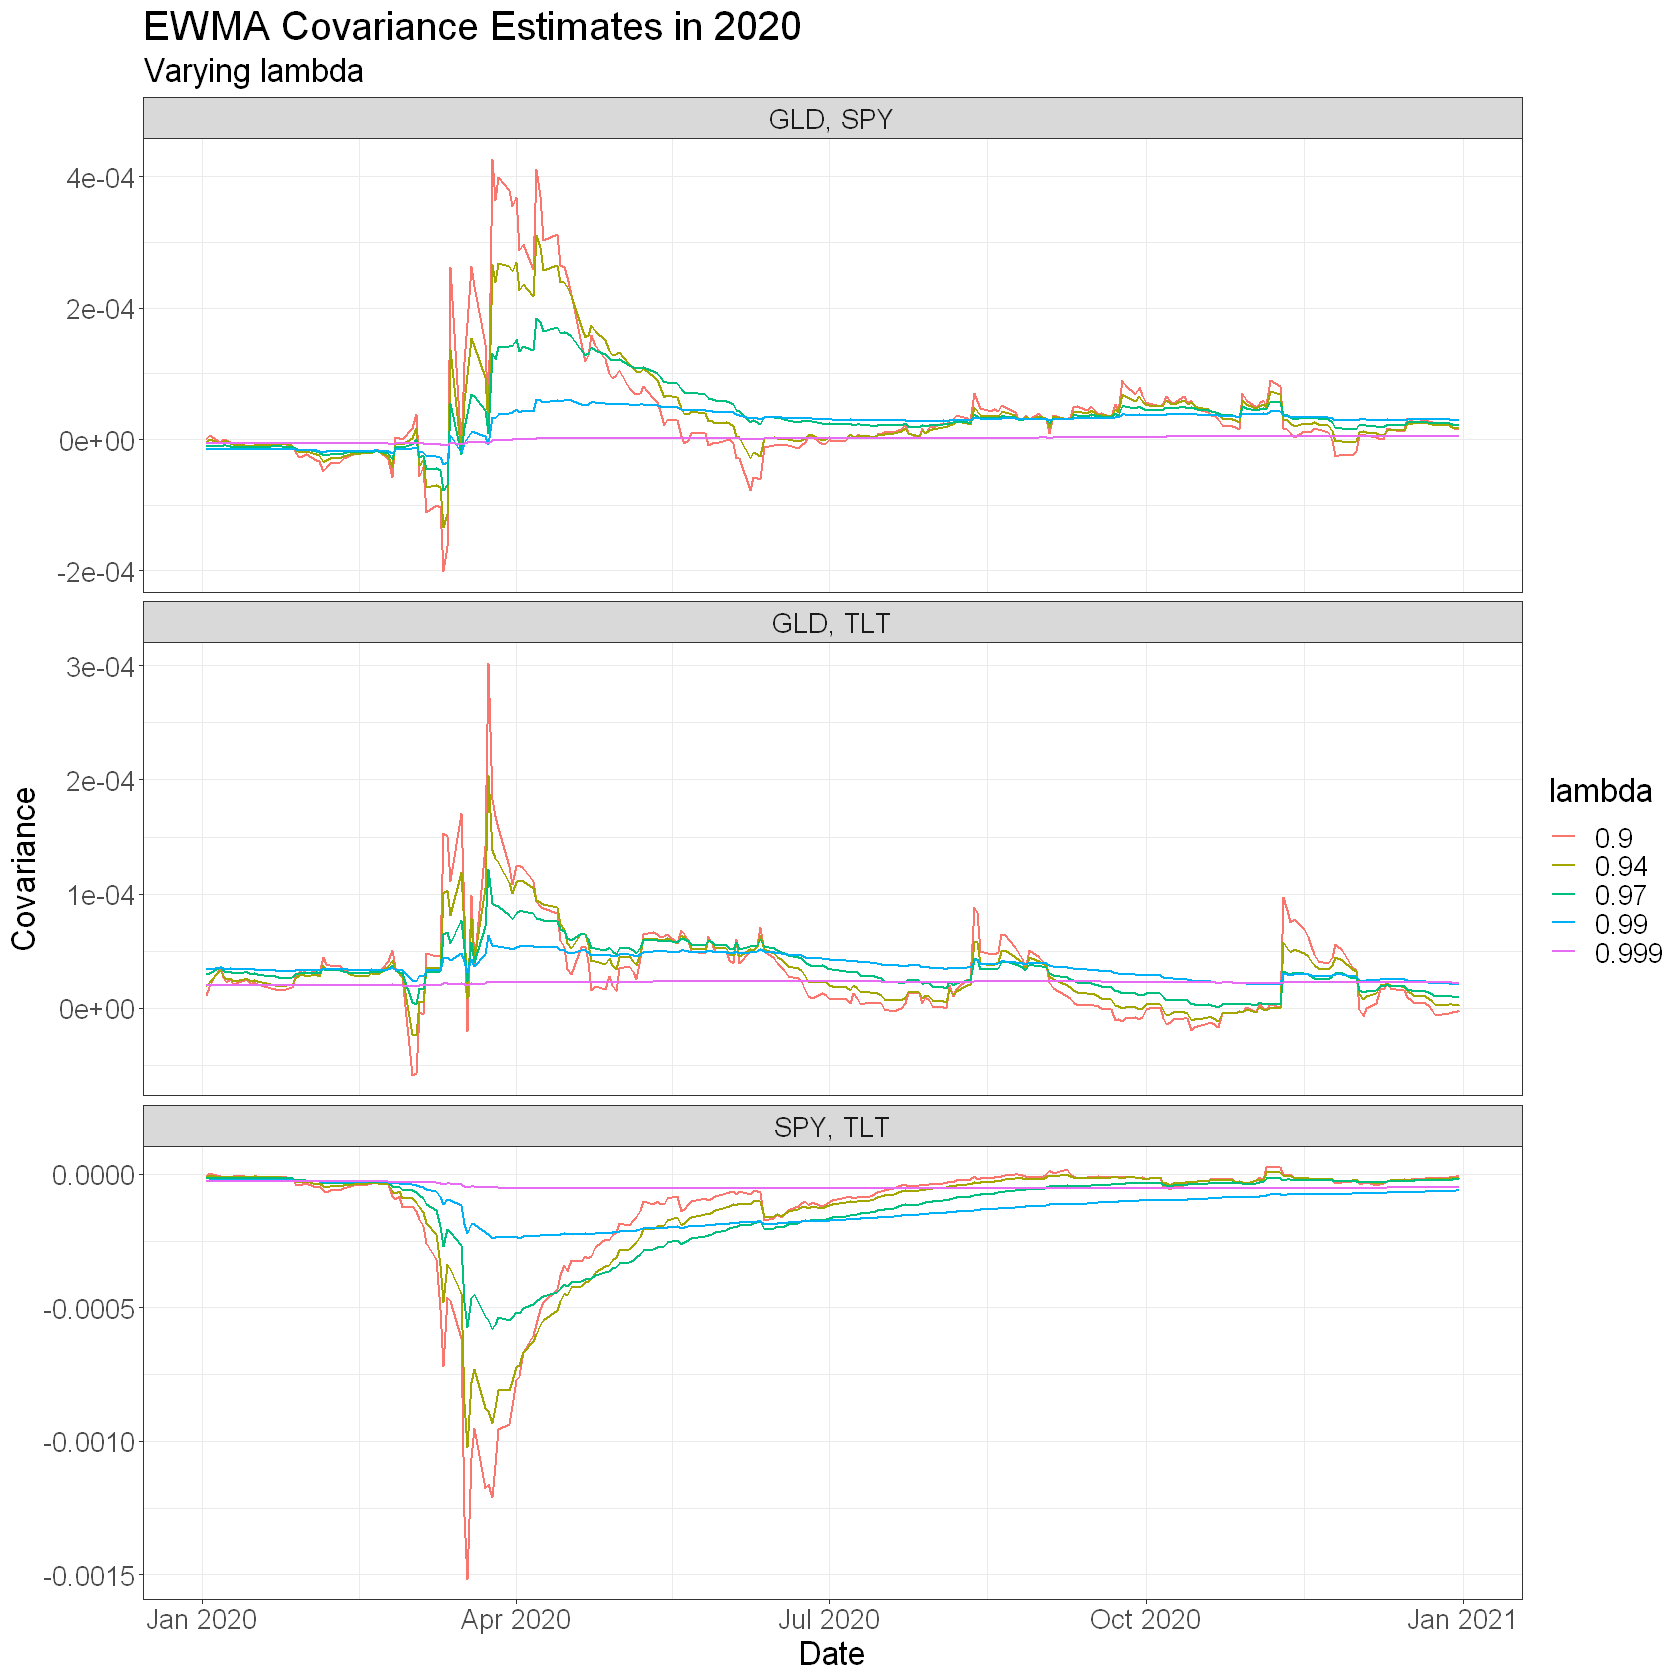

In [10]:
returns %>%
  full_join(returns, by = "Date") %>%
  na.omit() %>%
  ungroup() %>% 
  # drop diagonal 
  dplyr::filter(Ticker.x != Ticker.y) %>% 
  # get all combinations (Tickers) and remove duplicate combos (eg SPY-TLT, TLT-SPY)
  mutate(Tickers = ifelse(Ticker.x < Ticker.y, glue("{Ticker.x}, {Ticker.y}"), glue("{Ticker.y}, {Ticker.x}"))) %>%
  distinct(Date, Tickers, .keep_all = TRUE) %>%
  # calculate rolling pairwise ewma covariances
  group_by(Tickers) %>%
  arrange(Date, .by_group = TRUE) %>%
  mutate(
    lambda_0.90 = ewma_cov(log_return.x, log_return.y, lambda = 0.9, initialisation_wdw = wdw),
    lambda_0.94 = ewma_cov(log_return.x, log_return.y, lambda = 0.94, initialisation_wdw = wdw),
    lambda_0.97 = ewma_cov(log_return.x, log_return.y, lambda = 0.97, initialisation_wdw = wdw),
    lambda_0.99 = ewma_cov(log_return.x, log_return.y, lambda = 0.99, initialisation_wdw = wdw),
    lambda_0.999 = ewma_cov(log_return.x, log_return.y, lambda = 0.999, initialisation_wdw = wdw),
  ) %>%
  na.omit() %>%
  filter(Date >= "2020-01-01", Date <= "2020-12-31") %>%  
  select(Tickers, Date, starts_with("lambda")) %>%
  pivot_longer(cols = starts_with("lambda"), names_to = "lambda", values_to = "ewma_cov") %>% 
  mutate(lambda = as.factor(as.numeric(stringr::str_extract(lambda, "[0-9]+\\.[0-9]+")))) %>% 
  ggplot(aes(x = Date, y = ewma_cov, colour = lambda)) +
    geom_line(size=0.8) +
    facet_wrap(~Tickers, ncol = 1, scales = "free_y") +
    labs(
      title = "EWMA Covariance Estimates in 2020",
      subtitle = glue("Varying lambda"),
      y = "Covariance"
    )

The trade-off between responsiveness and stability is clear. Lower values of lambda will respond more quickly and extremely to changes, whereas higher values of lambda will respond more slowly but more smoothly. 

A sensible value of lambda will very much depend on your application, and you'll probably end up tuning it a bit to find what works. 

**Next time, we'll make this all a little more tangible when we have a look at one possible application - an Equal Risk Contribution portfolio optimisation problem.** 